# Instrumental Variables

Author: Greg Strabel

This notebook provides a brief introduction to instrumental variables (IV) and assumes a basic understanding of ordinary least squares regression (OLS). Instrumental variables is a method for dealing with endogenous regressors in order to recover a consistent estimator in a large class of statistical models. I first consider the cases of just-identified and over-identified linear parametric IV and then progress to nonlinear IV using the Generalized Method of Moments (GMM).

Recall that in OLS we are attempting to estimate $\beta$ in the equation $y = \beta 'x + \epsilon$ where both $y$ and $x$ are observed and $\epsilon$ is an unobserved error term. Here, $x$ is a $k \times 1$ vector. If we have a random sample with $n$ observations each of $y$ and $x$ we can construct an $n \times 1$ vector $Y$ and an $n \times k$ matrix $X$. OLS then estimates $\beta$ as: $$\hat{\beta} = \left( X'X \right) ^{-1}X'Y = \left( \sum_{i=1}^n X_{i, \cdot } X_{i, \cdot } ' \right) ^{-1} \left( \sum_{i=1}^n X_{i, \cdot } ' Y_i \right)$$

Consistency of $\hat{\beta}$ as an estimator for $\beta$ requires that $\mathbb{E} x \epsilon = 0$. However, this is often not the case. A simple model where this orthogonality condition fails to hold is as follow:
$$k = 3$$
$$w, v_1, v_2, c, \eta \sim  \mathrm{i.i.d.}  \mathcal{N}(0,1)$$
$$x = \begin{bmatrix}1 \\ w \\ \gamma_1 v_1 + \gamma_2 v_2  + \alpha c\end{bmatrix}$$

$$\epsilon = c + \eta$$
$$y = \beta ' x + \epsilon$$

In this setup, $\mathbb{E} x_3 \epsilon = \mathbb{E} \left( \gamma_1 v_1 c + \gamma_1 v_1 \eta + \gamma_2 v_2 c + \gamma_2 v_2 \eta + \alpha c^2 + \alpha c \eta \right) = \alpha$.

To see that this causes an issue, note that by the law of large numbers and the continuous mapping theorem,
$$(X'X)^{-1}X'Y \rightarrow^{a.s.} \left( \mathbb{E}xx' \right)^{-1} \mathbb{E}xy = \beta + \left( \mathbb{E}xx' \right)^{-1} \begin{bmatrix}0 \\ 0 \\ \alpha\end{bmatrix} = \beta + \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & \gamma_1^2 + \gamma_2^2 + \alpha^2\end{bmatrix}^{-1} \begin{bmatrix}0 \\ 0 \\ \alpha\end{bmatrix} = \beta + \begin{bmatrix} 0 \\ 0 \\ {\alpha \over \gamma_1^2 + \gamma_2^2 + \alpha^2}\end{bmatrix}$$

Hence, although OLS would provide consistent estimators of $\beta_1$ and $\beta_2$, the estimator for $\beta_3$ would be inconsistent. If $\alpha > 0$ then $\epsilon$ and $x_3$ are positively correlated; when $x_3$ is above its mean, $\epsilon$ tends to be above its mean. As a result, OLS will incorrectly attribute to $x_3$ some of the increase in $y$ that is due to high values of $\epsilon$. This produces an estimator $\hat{\beta_3}$ that exceeds the true value of $\beta_3$.

I now generate a dataset from this data generating process and use the R function lm to demonstrate this bias:

In [1]:
library(MASS)
library(dplyr)
library(tidyr)
library(gmm)
library(ggplot2)
library(repr)
options(repr.plot.width = 5, repr.plot.height = 4, warn = -1)
#


Attaching package: 'dplyr'

The following object is masked from 'package:MASS':

    select

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Loading required package: sandwich


In [2]:
# Generate Data

genData <- function(nobs, alpha, gamma, beta){
    W <- rnorm(nobs)
    V1 <- rnorm(nobs)
    V2 <- rnorm(nobs)
    C <- rnorm(nobs)
    eta <- rnorm(nobs)
    #mvrnorm(nobs ,mu = rep(0,4), Sigma = diag(4))
    X <- cbind(rep(1,nobs), W, gamma[1]*V1 + gamma[2]*V2 + alpha * C)
    colnames(X) <- c('x1','x2','x3') 
    eps <- C + eta
    Y <- X %*% beta + eps
    df <- data.frame(Y, X, V1, V2, eps)
    return(df)
}

set.seed(0)

nobs <- 10000
alpha = 0.9
gamma <- c(sqrt(0.5),sqrt(0.5))
beta = c(0.5, -1.2, 1)

df <- genData(nobs, alpha, gamma, beta)

# Take a look at the data
head(df)

Y,x1,x2,x3,V1,V2,eps
-5.1992153,1,1.2629543,-2.6859461,-1.21955126,-0.5288658,-1.49772406
0.3388716,1,-0.3262334,-0.4150303,-1.20146018,0.1329492,-0.13757809
-3.2649818,1,1.3297993,-1.6748088,-0.49604255,-0.2724691,-0.49441383
-0.7973456,1,1.2724293,0.2733204,0.06693112,0.6429857,-0.04375085
1.4968218,1,0.4146414,1.9574790,-0.05694914,0.9979110,-0.46308744
3.8167734,1,-1.5399500,0.6657227,0.25558017,-1.0999127,0.80311064


In [3]:
#Fit OLS use the R function lm
lm_results <- lm(Y ~ x1 + x2 + x3 - 1, df)
lm_results


Call:
lm(formula = Y ~ x1 + x2 + x3 - 1, data = df)

Coefficients:
     x1       x2       x3  
 0.4852  -1.1951   1.5194  


Clearly, the coefficient on $x_3$, $\left(\hat{\beta_3}\right)$, is inconsistent. The goal of instrumental variables is to recover a consistent estimator for this parameter.

Intuitively, the idea behind instrumental variables is simple. The inconsistency problem above is a result of the correlation between $x_3$ and $\epsilon$. The instrumental variables approach solves this problem by splitting $x_3$ into two parts, the first of which is uncorrelated with $\epsilon$ and therefore can be used in a regression to recover a consistent estimator of $\beta_3$. To split $x_3$, we use an 'instrumental variable' that is correlated with $x_3$ but uncorrelated with $\epsilon$. The variation in $x_3$ that can be explained by variation in the instrument will be uncorrelated with $\epsilon$ and therefore can be used to consistently estimate $\beta_3$.

### Just-Identified Linear I.V.

To recover a consistent estimator for $\beta_3$ we can use $v_1$ as an instrument for $x_3$. Setting $z = \begin{bmatrix}1 \\ w \\ v_1\end{bmatrix}$, note that $$\mathbb{E} z \epsilon = 0$$
Therefore, $$\mathbb{E} z x' = \mathbb{E} \begin{bmatrix}1 \\ w \\ v_1\end{bmatrix} \begin{bmatrix}1 & w & \gamma_1 v_1 + \gamma_2 v_2 + \alpha c\end{bmatrix} = \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & \gamma_1\end{bmatrix}$$
and $$\mathbb{E} z y = \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & \gamma_1\end{bmatrix} \beta$$

It follows from the law of large numbers and the Continuous Mapping Theorem that the estimator $$\beta_{IV} = \left( Z'X \right)^{-1} Z'Y \rightarrow^{a.s.} \left( \mathbb{E} z x' \right)^{-1} \mathbb{E} z y = \beta$$

I use the ivreg function in the AER library to fit this model:

In [4]:
library(AER)
ivreg_results <- ivreg(Y ~ x1 + x2 + x3 -1 | x1 + x2 + V1 -1, data = df)
ivreg_results

Loading required package: car

Attaching package: 'car'

The following object is masked from 'package:dplyr':

    recode

Loading required package: lmtest
Loading required package: zoo

Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric

Loading required package: survival



Call:
ivreg(formula = Y ~ x1 + x2 + x3 - 1 | x1 + x2 + V1 - 1, data = df)

Coefficients:
     x1       x2       x3  
 0.4866  -1.1896   1.0373  


### Over-Identified Linear I.V.

In the example above, we used one instrument for each variable in the regression; $x_1$ and $x_2$ instrumented for themselves since they were already orthogonal to $\epsilon$ while $v_1$ was the instrument for $x_3$. The symmetry of the problem in $v_1$ and $v_2$ suggests that we could have used $v_2$ instead. In fact, we can use both $v_1$ and $v_2$ simultaneously in an over-identified instrumental variable model.

Redefine $z = \begin{bmatrix}1 \\ w \\ v_1 \\ v_2\end{bmatrix}$ and note that we still have $$\mathbb{E} z \epsilon = 0$$

We now have $$\mathbb{E} z x' = \mathbb{E} \begin{bmatrix}1 \\ w \\ v_1 \\ v_2\end{bmatrix} \begin{bmatrix}1 & w & \gamma_1 v_1 + \gamma_2 v_2 + \alpha c\end{bmatrix} = \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & \gamma_1\\0 & 0 & \gamma_2\end{bmatrix}$$
$$\mathbb{E} z z' = \mathbb{I}_4$$
and $$\mathbb{E} z y = \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & \gamma_1\\0 & 0 & \gamma_2\end{bmatrix} \beta$$

It follows from the law of large numbers and the Continuous Mapping Theorem that the estimator $$\beta_{IV} = \left( X'Z \left( Z'Z \right)^{-1} Z'X \right)^{-1} X'Z \left( Z'Z \right)^{-1} Z'Y \rightarrow^{a.s.} \left( \begin{bmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & \gamma_1 & \gamma_2\end{bmatrix} \mathbb{I}_4 \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & \gamma_1\\0 & 0 & \gamma_2\end{bmatrix}\right)^{-1} \begin{bmatrix}1 & 0 & 0 & 0\\0 & 1 & 0 & 0\\0 & 0 & \gamma_1 & \gamma_2\end{bmatrix} \mathbb{I}_4 \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & \gamma_1\\0 & 0 & \gamma_2\end{bmatrix} \beta = \beta$$

Once again, we can use the ivreg function in the AER library to fit the model:

In [5]:
library(AER)
overID_ivreg_results <- ivreg(Y ~ x1 + x2 + x3 -1 | x1 + x2 + V1 + V2 -1, data = df)
overID_ivreg_results


Call:
ivreg(formula = Y ~ x1 + x2 + x3 - 1 | x1 + x2 + V1 + V2 - 1,     data = df)

Coefficients:
     x1       x2       x3  
 0.4866  -1.1895   1.0314  


At this point, one might inquire as to why we would bother with the over-identified model when the just-identified model has a mathematically simpler representation. It is easy to show that under 'standard' assumptions, both estimators are asymptotically normal:
$$\sqrt{n}\left(\hat{\beta} - \beta \right) \Rightarrow \mathcal{N}\left(0,\sigma_{\epsilon}^2 \left( \left[ \mathbb{E} \left( xz' \right) \right] \left[ \mathbb{E} \left( zz' \right) \right]^{-1} \left[ \mathbb{E} \left( zx' \right) \right] \right)^{-1} \right)$$

In the just-identified model, the variance reduces to
$$\sigma_{\epsilon}^2 \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & {1\over \gamma_1^2} \end{bmatrix}$$
whereas in the over-identified model, the variance reduces to
$$\sigma_{\epsilon}^2 \begin{bmatrix}1 & 0 & 0\\0 & 1 & 0\\0 & 0 & {1\over \gamma_1^2 + \gamma_2^2} \end{bmatrix}$$

It follows that the estimator for $\beta_3$ in the over-identified model is more efficient (lower variance) than the estimator in the just-identified model. Intuitively, by using both $v_1$ and $v_2$, rather than just $v_1$, as instruments for $x_3$, we are using additional information that allows us to get a sharper estimate of $\beta_3$. To see this result, I simulate 500 seperate datasets from the data generating process, fit both models and plot both a boxplot and a kernel density estimate of resulting $\hat{\beta_3}$'s.

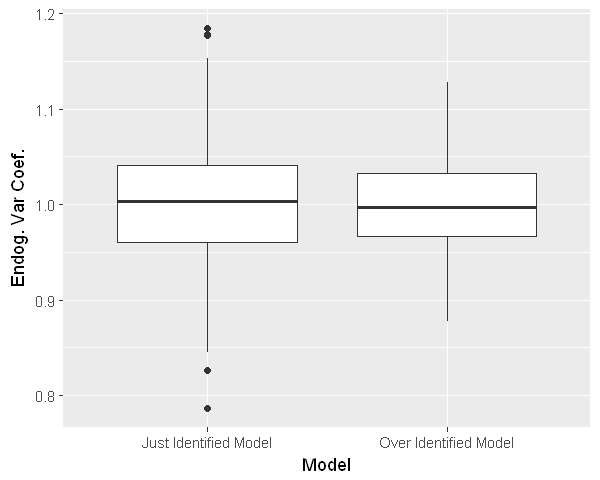

In [6]:
nsim = 500 # number of simulations
nobs <- 1000
alpha = 0.9
gamma <- c(sqrt(0.5),sqrt(0.5))
beta = c(0.5, -1.2, 1)
justIDed_coeff <- c()
overIded_coeff <- c()
for(i in 1:500){
df_ <- genData(nobs, alpha, gamma, beta)
    justIDed_coeff <- c(justIDed_coeff,
                        ivreg(Y ~ x1 + x2 + x3 -1 | x1 + x2 + V1 -1, data = df_)$coefficients[3])
    overIded_coeff <- c(overIded_coeff,
                       ivreg(Y ~ x1 + x2 + x3 -1 | x1 + x2 + V1 + V2 -1, data = df_)$coefficients[3])
}

df_sim <- data.frame(justIDed_coeff,overIded_coeff) %>%
    rename(`Just Identified Model` = justIDed_coeff, `Over Identified Model` = overIded_coeff) %>%
    gather()
ggplot(df_sim, aes(key,value)) + geom_boxplot() + labs(x = "Model", y = 'Endog. Var Coef.')

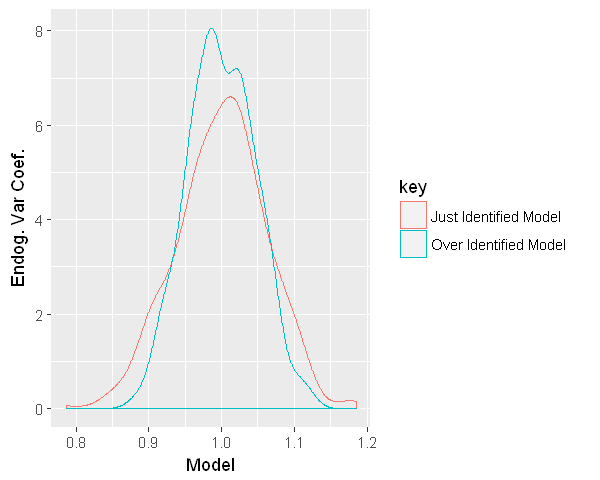

In [7]:
ggplot(df_sim, aes(value, group = key, color = key)) +
    geom_density() + labs(x = "Model", y = 'Endog. Var Coef.')

## Instrumental Variables with Nonparametric Two-Stage Least Squares

Finally, we consider using instruments in a nonlinear model. This approach is inspired by [Newey and Powell (2003)](https://eml.berkeley.edu/~powell/npiv.pdf). Our example data generating process is the same as above except that we replace $$y = \beta'x + \epsilon$$ with $$y = g\left(x,\beta\right) + \epsilon = \frac{1}{1 + \exp(4\beta'x)} + 
\epsilon$$

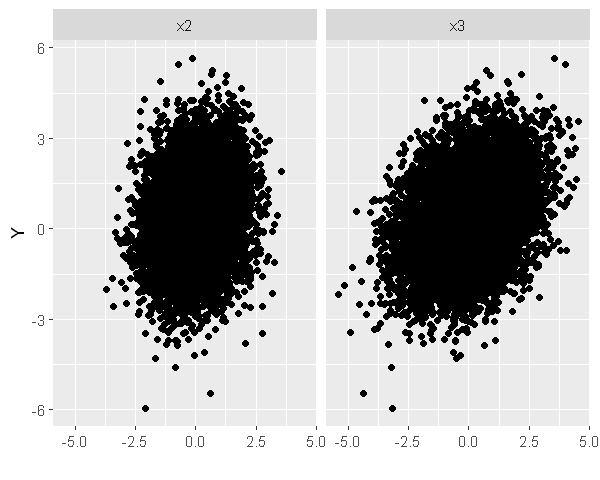

In [8]:
f <- function(beta,df){
    linpred <- as.matrix(df) %*% beta
    y <- 1/(1+exp(4*linpred))
    return(as.numeric(y))
}

df$Y <- f(beta,df %>% select(x1,x2,x3)) + df$eps

df %>% select(x2,x3,Y) %>% gather('var','val',1:2) %>%
    ggplot(aes(val,Y)) + facet_grid(. ~ var) + geom_point() + labs(x = '', y='Y')

Because $x_3$ is endogenous, the observed relation between $x_3$ and $y$ is misleading. Visually, it appears that $y$ is an increasing function of $x_3$. In fact, $y$ is a decreasing function of $x_3$, but the endogeneity of $x_3$ results in $\epsilon$'s contamination of this relationship.

`geom_smooth()` using method = 'gam'
`geom_smooth()` using method = 'gam'


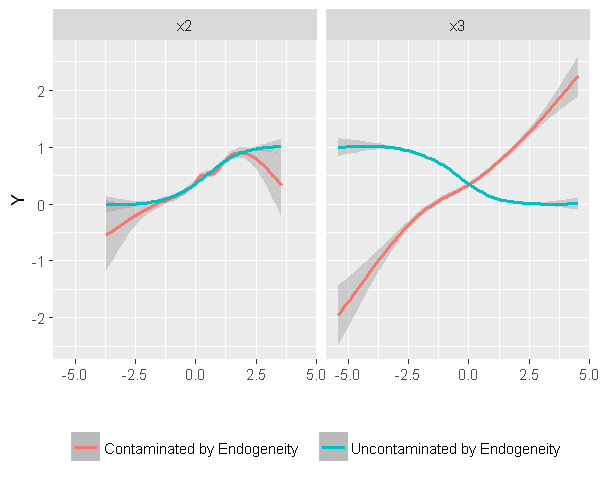

In [9]:
df2 <- df
df2$Y_xeps = f(beta,df2 %>% select(x1,x2,x3))
df2 %>% select(x2,x3,Y,Y_xeps) %>% gather('var','val',1:2) %>%
    ggplot() + facet_grid(. ~ var) + geom_smooth(aes( val, Y, color = 'Contaminated by Endogeneity')) +
    geom_smooth(aes( val, Y_xeps, color = 'Uncontaminated by Endogeneity')) +
    theme(legend.position = 'bottom', legend.title = element_blank()) +
    labs(x = '', y = 'Y')

To recover an estimate of the true relationship between $y$ and $x_3$, I perform nonparametric two-stage least squares. In the first stage I regress a set of basis function transforms of $x$ (denote these by $\left\{F_k\right\}$) on a set of basis function transforms of the exogenous components of $x$ and the instruments. Intuitively, the first stage acts as a nonparametric filter for removing the endogeneity.

In the second stage, I regress $y$ on the set of estimated basis functions $\left\{\hat{F}_k\right\}$

The basis function transforms I use are low degree polynomials and their interactions with Gaussian radial basis functions.

In [10]:
library(caret)
df_train <- df2
# Scale and center data
preProc <- preProcess(df_train[c('x2','x3','V1','V2')])
df_train[c('x2','x3','V1','V2')] <- predict(preProc,df_train[c('x2','x3','V1','V2')])
# Create Gaussian radial basis transform
df_train <- df_train %>% mutate(grbf_step1 = exp(-(x1^2 + x2^2 + V1^2 + V2^2)))
# Fit stage 1 regressions
alpha1.fit <- lm(x3 ~ x1 + x2 + V1 + V2 + grbf_step1*V1 + grbf_step1*V2 -1, df_train)
alpha2.fit <- lm(grbf_step1*x3 ~ x1 + x2 + V1 + V2 + grbf_step1*V1 + grbf_step1*V2 -1, df_train)
alpha3.fit <- lm(grbf_step1*x2 ~ x1 + x2 + V1 + V2 + grbf_step1*V1 + grbf_step1*V2 -1, df_train)
alpha4.fit <- lm(I(grbf_step1*x3^2) ~ x1 + x2 + V1 + V2 + grbf_step1*V1 + grbf_step1*V2 -1, df_train)
alpha5.fit <- lm(I(grbf_step1*x2^2) ~ x1 + x2 + V1 + V2 + grbf_step1*V1 + grbf_step1*V2 -1, df_train)
# Predict first stage models
df_train$F_hat1 <- predict(alpha1.fit, df_train %>% select(x1,x2,V1,V2,grbf_step1))
df_train$F_hat2 <- predict(alpha2.fit, df_train %>% select(x1,x2,V1,V2,grbf_step1))
df_train$F_hat3 <- predict(alpha3.fit, df_train %>% select(x1,x2,V1,V2,grbf_step1))
df_train$F_hat4 <- predict(alpha4.fit, df_train %>% select(x1,x2,V1,V2,grbf_step1))
df_train$F_hat5 <- predict(alpha5.fit, df_train %>% select(x1,x2,V1,V2,grbf_step1))
# Create second set of radial basis transforms
df_train <- df_train %>% mutate(grbf_step2 = exp(-(F_hat1^2 + F_hat2^2 + F_hat3^2 + F_hat4^2 + F_hat5^2)))
# Fit second stage regression
NP2SLS_step2 <- lm(Y ~ x1 + x2 + F_hat1 + F_hat2 + F_hat3 + F_hat4 + F_hat5 +
                            grbf_step2*F_hat1 + grbf_step2*F_hat2 +
                            grbf_step2*F_hat3 + grbf_step2*F_hat4 +
                            grbf_step2*F_hat5 +
                            I(grbf_step2*F_hat1^2) + I(grbf_step2*F_hat2^2) +
                            I(grbf_step2*F_hat3^2) + I(grbf_step2*F_hat4^2) +
                            I(grbf_step2*F_hat5^2) 
                             -1, df_train)
# Predict second stage model
df_train$NP_y_pred <- predict(NP2SLS_step2,df_train)

Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:survival':

    cluster



`geom_smooth()` using method = 'gam'
`geom_smooth()` using method = 'gam'
`geom_smooth()` using method = 'gam'


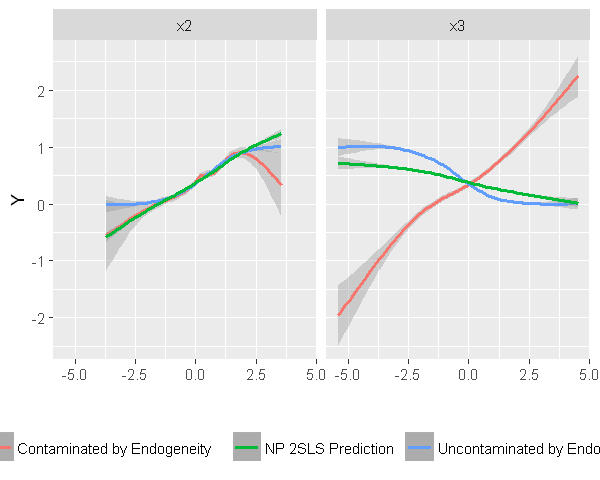

In [11]:
df2$NP_y_pred <- df_train$NP_y_pred
df2 %>% select(x2,x3,Y,Y_xeps,NP_y_pred) %>% gather('var','val',1:2) %>%
    ggplot() + facet_grid(. ~ var) + geom_smooth(aes(val,Y,color='Contaminated by Endogeneity')) +
    labs(x = '', y='Y') + geom_smooth(aes(val,Y_xeps,color='Uncontaminated by Endogeneity')) +
    geom_smooth(aes(val,NP_y_pred,color='NP 2SLS Prediction')) +
    theme(legend.position = 'bottom', legend.title = element_blank())

# TODO:

Create more plots to further illuminate the intuition behind NP 2SLS

Recommend that the reader try adding more basis functions to the series expansion or try other nonparametric estimators (kernel regression, wavelets).

Observations: 42
Variables: 8
$ x1  <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...
$ x2  <dbl> -3.70323584, -1.63601199, -1.28101768, -1.03453876, -0.83456905...
$ x3  <dbl> 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.0...
$ key <chr> "x2", "x2", "x2", "x2", "x2", "x2", "x2", "x2", "x2", "x2", "x2...
$ val <dbl> -3.70323584, -1.63601199, -1.28101768, -1.03453876, -0.83456905...
$ V1  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ V2  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
$ f   <dbl> 2.579857e-09, 5.259391e-05, 2.889740e-04, 9.427314e-04, 2.45803...


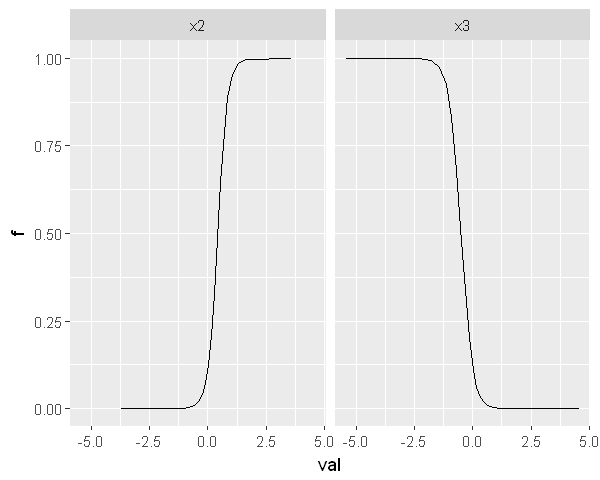

In [58]:
quants <- seq(0,1,0.05)
df3 <- data.frame(x1 = rep(1,2*length(quants)))
df3$x2 <- c(quantile(df$x2,quants),rep(0,length(quants)))
df3$x3 <- c(rep(0,length(quants)),quantile(df$x3,quants))
df3$key <- c(rep('x2',length(quants)),rep('x3',length(quants)))
df3$val <- ifelse(df3$key=='x2',df3$x2,df3$x3)
df3$V1 <- 0
df3$V2 <- 0
df3$f <- f(beta,df3 %>% select(x1,x2,x3))

df3 %>% ggplot() + geom_line(aes(val,f)) + facet_grid(.~key)

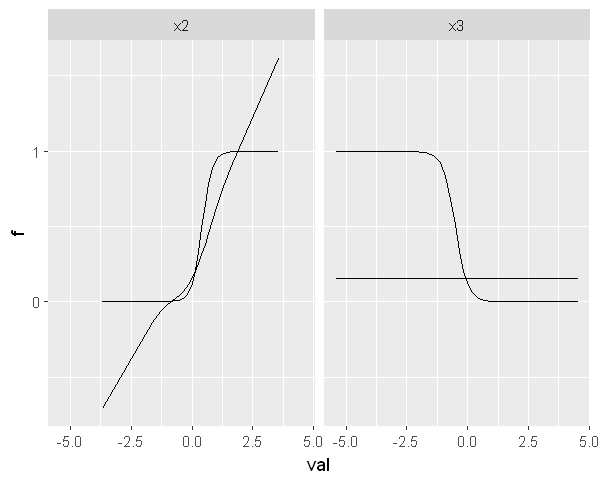

In [60]:
df3 <- df3 %>% mutate(grbf_step1 = exp(-(x1^2 + x2^2 + V1^2 + V2^2))) 
df3$F_hat1 <- predict(alpha1.fit, df3 %>% select(x1,x2,V1,V2,grbf_step1))
df3$F_hat2 <- predict(alpha2.fit, df3 %>% select(x1,x2,V1,V2,grbf_step1))
df3$F_hat3 <- predict(alpha3.fit, df3 %>% select(x1,x2,V1,V2,grbf_step1))
df3$F_hat4 <- predict(alpha4.fit, df3 %>% select(x1,x2,V1,V2,grbf_step1))
df3$F_hat5 <- predict(alpha5.fit, df3 %>% select(x1,x2,V1,V2,grbf_step1))
#df2$F_hat6 <- predict(alpha6.fit, df2 %>% select(x1,x2,V1,V2,grbf_step1))
df3 <- df3 %>% mutate(grbf_step2 = exp(-(F_hat1^2 + F_hat2^2 + F_hat3^2 + F_hat4^2 + F_hat5^2 #+ F_hat6^2
                                        )))
df3$NP_y_pred <- predict(NP2SLS_step2,df3)
df3 %>% ggplot() + geom_line(aes(val,f)) + geom_line(aes(val,NP_y_pred)) + facet_grid(.~key)

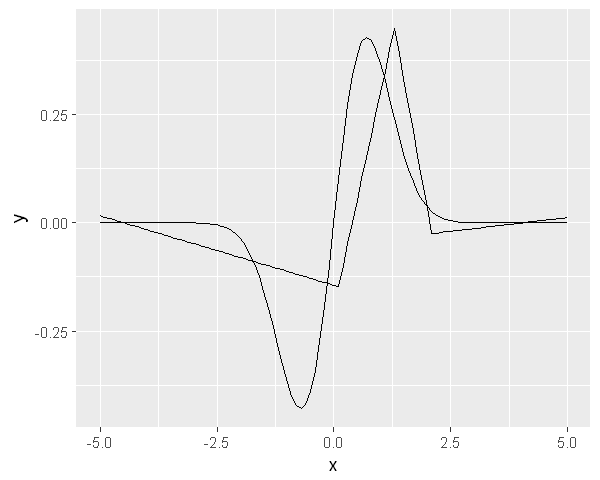

In [33]:
df_test <- data.frame(x = seq(-5,5,0.1))
df_test$y <- exp(-df_test$x^2)*df_test$x
library(mda)
mars.fit <- mars(df_test$x,df_test$y)
df_test$y_hat <- predict(mars.fit,df_test$x)
ggplot(df_test) + geom_line(aes(x,y)) + geom_line(aes(x,y_hat))

In [35]:
NP2SLS <- function(df,exog_vars,instr,endog_vars,target_var){
    df_ <- df
    df_$grbf1_ = exp(-rowSums(df_[c(exog_vars,instr)]^2))
    df_$grbf2_ = exp(-rowSums(df_[c(exog_vars,endog_vars)]^2))
    l <- list()
    for(i in c(exog_vars,endog_vars)){
        l(i <- lm(target_var))
    }
}

NP2SLS(df,c("x1","x2"),c("V1","V2"),c("x3"))
#head(df)